In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from glob import glob
import os
import shutil
import subprocess
from src import *
import matplotlib.pyplot as plt

In [35]:
def plot_alignment(signals):
    sr = 44100
    k = int(sr * 60 * 2)
    each = 100
    plt.figure(figsize=(20, 10))
    for signal in signals:
        plt.plot(signal[:k:each], alpha=0.5)

In [37]:
def align_signals(reference, target, sr=44100):
    s1 = (reference - reference.mean()) / reference.std()
    s2 = (target - target.mean()) / target.std()
    
    mid = len(s2) // 2
    kernel_from = mid - sr * 60 * 10
    kernel_to = mid + sr * 60 * 10

    s1_kernel = s1[kernel_from: kernel_to]
    loss_best = np.inf

    for dt in np.arange(-10, 10, 0.1):
        dx = round(dt * sr)

        s2_kernel = s2[kernel_from + dx: kernel_to + dx]

        loss = (s1_kernel - s2_kernel).pow(2).sum()

        if loss < loss_best:
            loss_best = loss
            dx_best = -dx

    if dx_best > 0:
        target = torch.cat([torch.zeros(dx_best), target])
    else:
        target = torch.cat([target, torch.zeros(abs(dx_best))])

    return target

# Part I

In [24]:
signal_1, sr = load_audio_wav('data/audio/12_RX100.MP4.wav', True)
signal_2 = load_audio_wav('data/audio/12_iphone.MP4.wav')
signal_3 = load_audio_wav('data/audio/12_Mobius.MP4.wav')

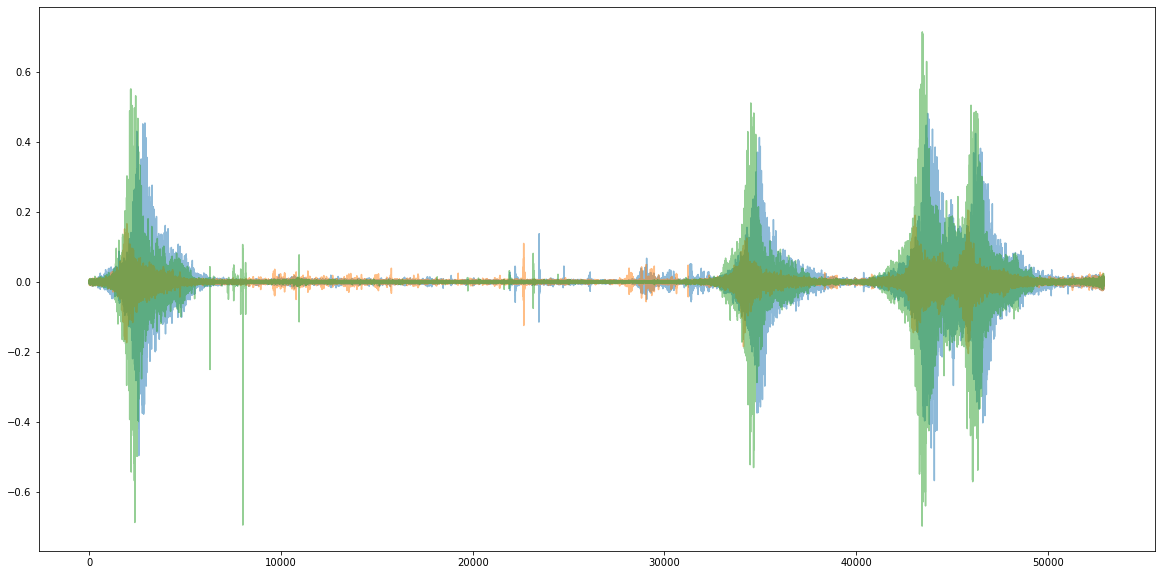

In [38]:
plot_alignment([signal_1, signal_2, signal_3])

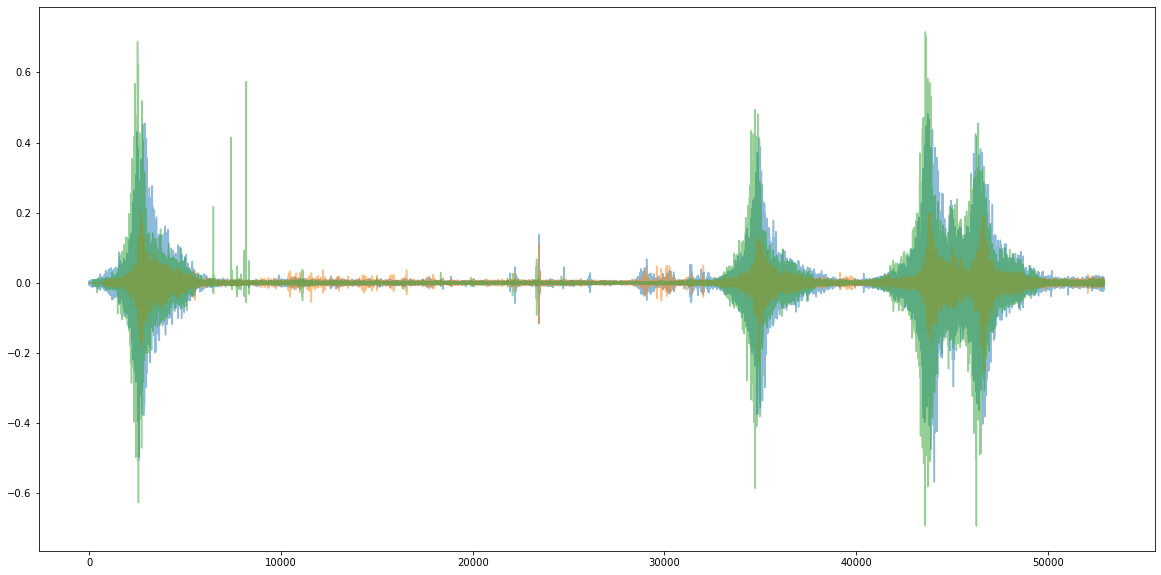

In [39]:
s2 = align_signals(signal_1, signal_2)
s3 = align_signals(signal_1, signal_3)

plot_alignment([signal_1, s2, s3])

In [208]:
torch.save([signal_1, sr1], 'data/audio_tensors/12_RX100.MP4.pt')
torch.save([s2, sr2], 'data/audio_tensors/12_iphone.MP4.pt')
torch.save([s3, sr3], 'data/audio_tensors/12_Mobius.MP4.pt')

# Part II

In [41]:
model, config = load_model_locally('one_location', 'rvce')
config.normalization = 'global'
transformation = create_transformation(config)

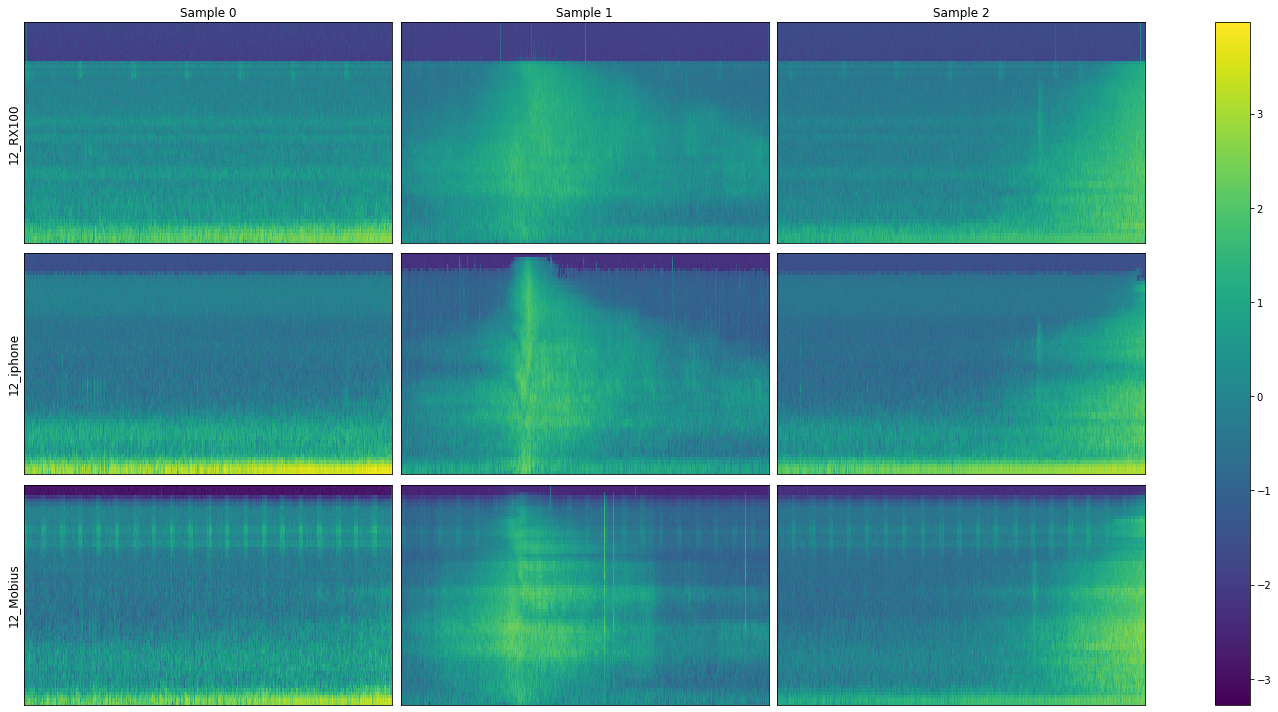

In [43]:
n_domains = 3
n_samples = 3

s1, sr1 = torch.load('data/audio_tensors/12_RX100.MP4.pt')
s2, sr2 = torch.load('data/audio_tensors/12_iphone.MP4.pt')
s3, sr3 = torch.load('data/audio_tensors/12_Mobius.MP4.pt')

vmin = np.inf
vmax = -np.inf

features = defaultdict(list)

for i in range(n_samples):
    f_i = int(np.random.choice(len(s1)))
    f_j = int(f_i + 20 * sr1)
    
    for s in [s1, s2, s3]:
        X = s[f_i: f_j]
        X = transformation(X).squeeze()
        vmin = min(X.min(), vmin)
        vmax = max(X.max(), vmax)
        features[i].append(X)

fig, axes = plt.subplots(n_samples, n_domains, figsize=(20, 10))

for i in range(n_samples):
    for j in range(n_domains):
        ax = axes[i, j]
        im = ax.pcolormesh(features[j][i], vmin=vmin, vmax=vmax)
        
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

cols = [f'Sample {i}' for i in range(n_samples)]
rows = ['12_RX100', '12_iphone', '12_Mobius']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, size='large')
    
plt.tight_layout()
fig.colorbar(im, ax=axes.tolist());